In [18]:
from wrangle_data_funcs import *
from modelling_funcs import *
from predict_gw_scores import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from outputs.other_funcs import *

from scipy import stats

In [2]:
training_years, training_n_gws, pred_year, pred_gw, alpha, rolling_gws, features, model_func, avg_type, output = get_params()

In [3]:
training_df = get_training_df(training_years, training_n_gws, avg_type, alpha, rolling_gws)

c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


In [4]:
training_years, training_n_gws, pred_year, pred_gw, alpha, rolling_gws, features, model_func, avg_type, output = get_params()
# print(training_year, training_n_gws, pred_year, pred_gw, alpha, features, model, output)
training_df = get_training_df(training_years, training_n_gws, avg_type, alpha, rolling_gws)
training_df_scaled, _ = scale_df(training_df, features)
_ = test_model(training_df_scaled, features, model_func)
prediction_df = get_prediction_df(pred_year, pred_gw, avg_type, alpha, rolling_gws)
prediction_df_scaled, _ = scale_df(prediction_df, features)
pred_df = train_full_model(training_df_scaled, features, prediction_df_scaled, model_func)
pred_df = merge_ownership_data(pred_df)
pred_df_simple = pred_df[['full_name', 'position', 'team', 'ewma_total_points', 'predicted_points', 'owner']]

c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.295, 'DEF': 2.257, 'MID': 2.221, 'FWD': 2.528}


# Checking coeffs

In [5]:
def train_full_model(training_df, features, prediction_df, model_func):
    model_dict, _ = create_model(training_df, features, model_func, test=False)
    pred_df = predict_scores(prediction_df.dropna(), features, model_dict)
    return pred_df, model_dict

In [6]:
training_years, training_n_gws, pred_year, pred_gw, alpha, rolling_gws, features, model_func, avg_type, output = get_params()
# print(training_year, training_n_gws, pred_year, pred_gw, alpha, features, model, output)
training_df = get_training_df(training_years, training_n_gws, avg_type, alpha, rolling_gws)
training_df_scaled, _ = scale_df(training_df, features)
_ = test_model(training_df_scaled, features, model_func)
prediction_df = get_prediction_df(pred_year, pred_gw, avg_type, alpha, rolling_gws)
prediction_df_scaled, _ = scale_df(prediction_df, features)
pred_df, model_dict = train_full_model(training_df_scaled, features, prediction_df_scaled, model_func)
pred_df = merge_ownership_data(pred_df)
pred_df_simple = pred_df[['full_name', 'position', 'team', 'ewma_total_points', 'predicted_points', 'owner']]

c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.295, 'DEF': 2.257, 'MID': 2.221, 'FWD': 2.528}


In [7]:
coefs = pd.DataFrame({'GK': model_dict['GK'].coef_,
              'DEF': model_dict['DEF'].coef_,
              'MID': model_dict['MID'].coef_,
              'FWD': model_dict['FWD'].coef_}, index=features
              )

In [8]:
coefs.loc[['ewma_team_goals_nw_opponent', 'ewma_team_points_nw_opponent']]

,GK,DEF,MID,FWD
ewma_team_goals_nw_opponent,0.0,-0.0,0.0,-0.000000
ewma_team_points_nw_opponent,0.0,-0.0,-0.0,-0.012733


# Plotting these features

<Figure size 640x480 with 0 Axes>

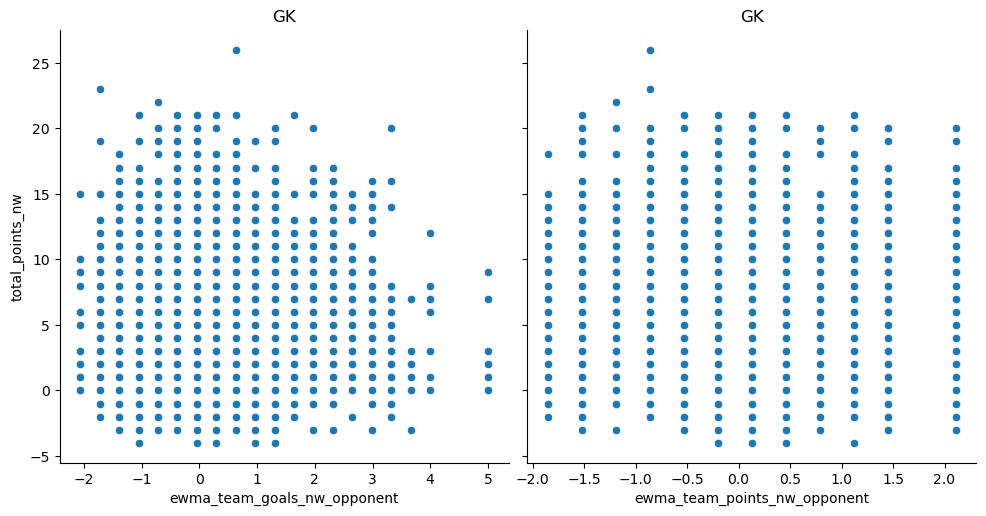

<Figure size 640x480 with 0 Axes>

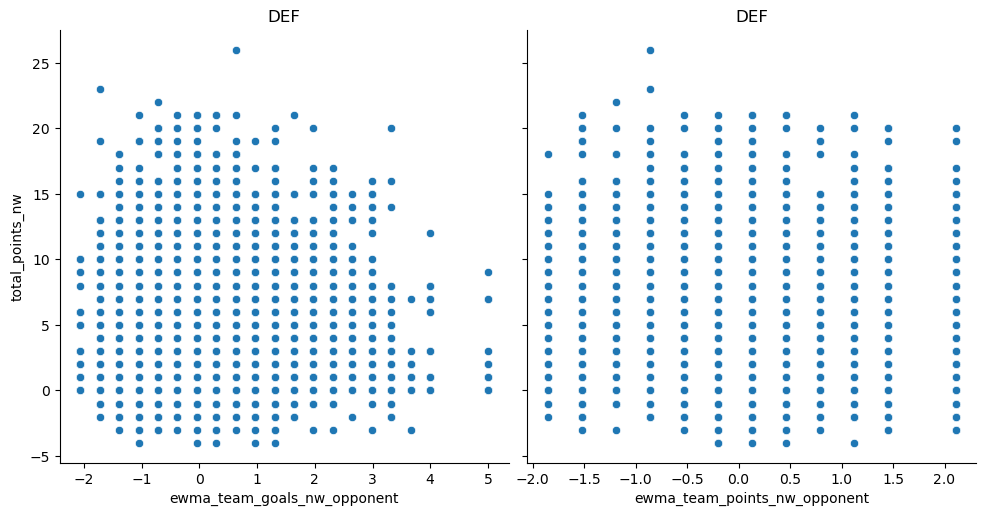

<Figure size 640x480 with 0 Axes>

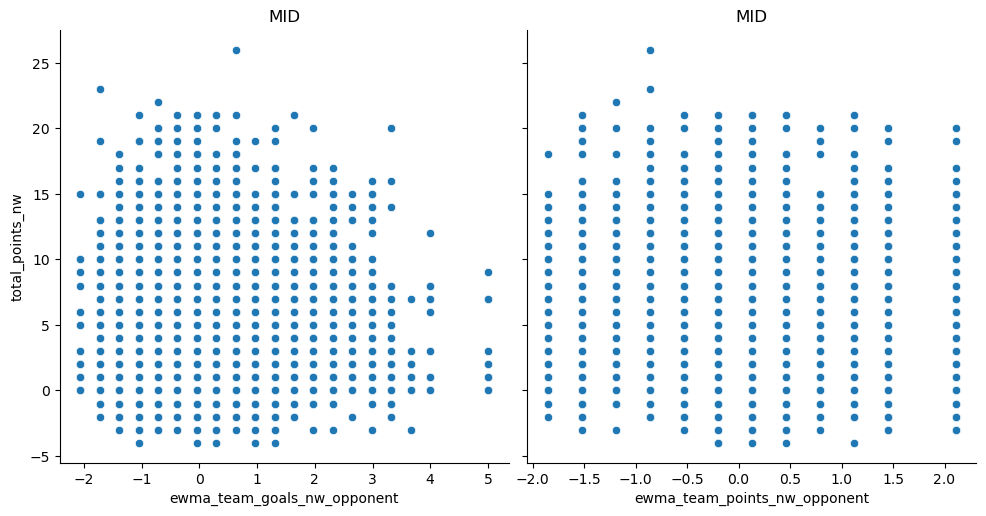

<Figure size 640x480 with 0 Axes>

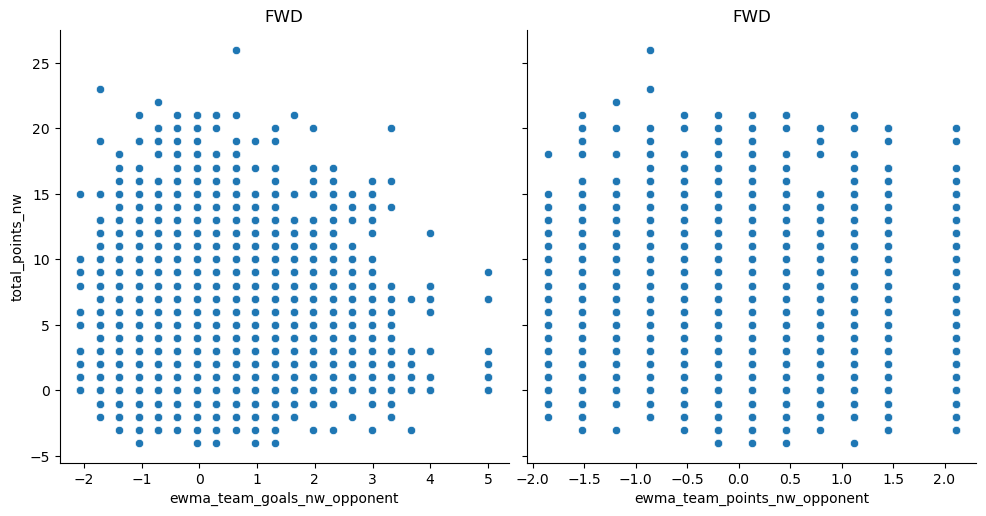

In [9]:
for position in ['GK', 'DEF', 'MID', 'FWD']:
    plt.figure(f'{position} ewma_team_goals_nw_opponent vs total_points_nw')
    ax1 = sns.pairplot(training_df_scaled, x_vars=['ewma_team_goals_nw_opponent', 'ewma_team_points_nw_opponent'], y_vars='total_points_nw', height=5, aspect=1)
    ax1.set(title=position)

In [36]:
training_df_scaled['total_points_nw'] = training_df_scaled['total_points_nw'].astype(float)

In [40]:
training_df_scaled['ewma_team_goals_nw_opponent'].value_counts()

ewma_team_goals_nw_opponent
-0.044460    6460
-0.381222    5745
-0.717984    5530
 0.292303    4773
-1.054746    4392
 0.629065    4175
 0.965827    2918
 1.302590    2662
-1.391509    2657
 1.639352    1309
-1.728271    1151
 1.976114     610
 2.312877     528
 2.649639     269
-2.065033     246
 2.986401     222
 3.323164     157
 3.659926      58
 5.006975      33
 3.996688      30
Name: count, dtype: int64

In [37]:
tmp = training_df_scaled.groupby('ewma_team_goals_nw_opponent').mean(numeric_only=True).reset_index()

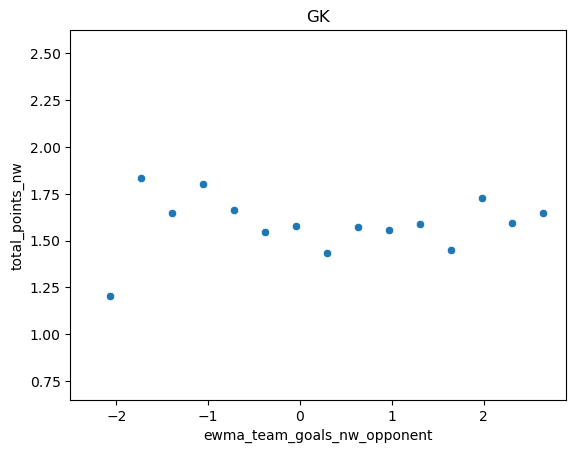

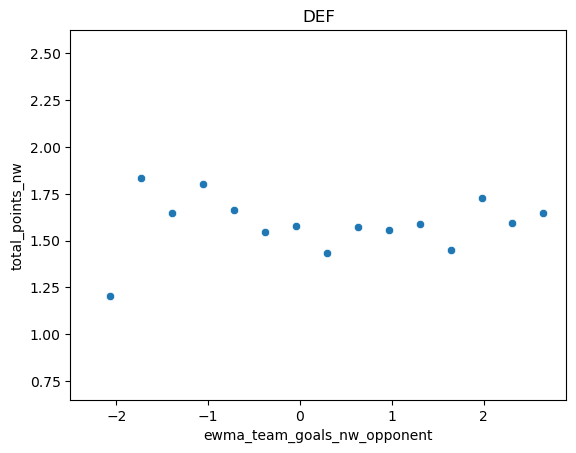

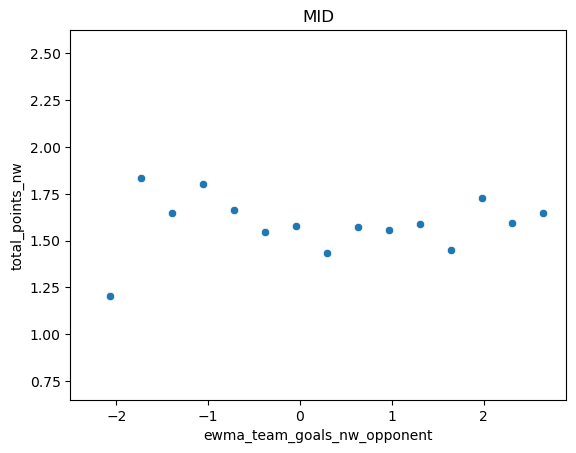

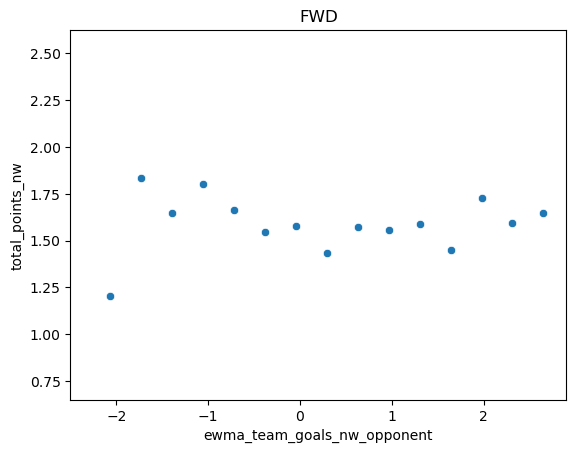

In [43]:
for position in ['GK', 'DEF', 'MID', 'FWD']:
    plt.figure(f'{position} ewma_team_goals_nw_opponent vs total_points_nw')
    ax1 = sns.scatterplot(data=tmp, x='ewma_team_goals_nw_opponent', y='total_points_nw')
    ax1.set(title=position, xlim=(-2.5, 2.9))

<Axes: xlabel='ewma_team_goals_nw_opponent', ylabel='total_points_nw'>

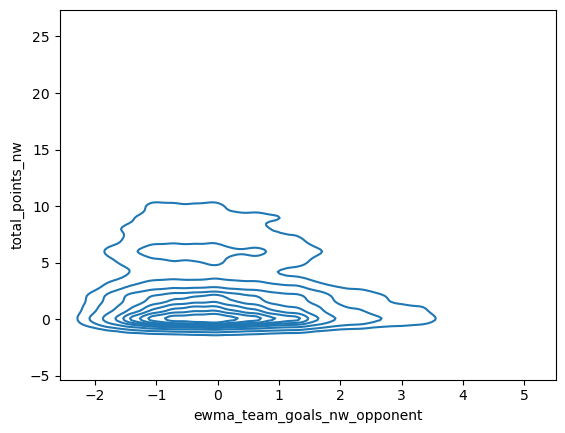

In [10]:
sns.kdeplot(training_df_scaled, x='ewma_team_goals_nw_opponent', y='total_points_nw')

LinregressResult(slope=np.float64(-0.04957550398317932), intercept=np.float64(1.5972225384177576), rvalue=np.float64(-0.018623381215689468), pvalue=np.float64(9.486250884313173e-05), stderr=np.float64(0.01269951924905014), intercept_stderr=np.float64(0.012699519249050148))

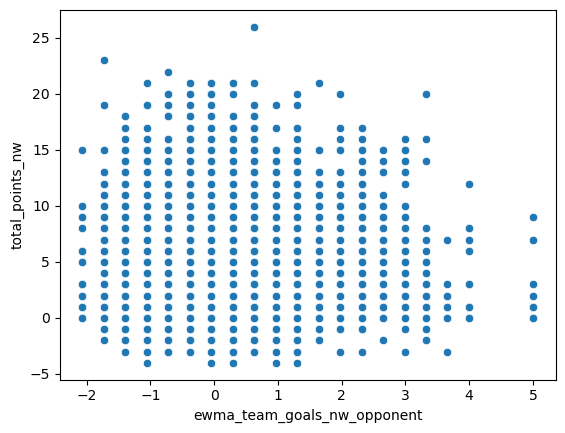

In [27]:
x = training_df_scaled['ewma_team_goals_nw_opponent']
y = training_df_scaled['total_points_nw']
sns.scatterplot(data=training_df_scaled, x=x, y=y)

stats.linregress(x.to_list(), y.to_list())